In [1]:
%run ../initlibs.py cryptomomentum dark

from models.turtless_model import TurtlesGenerator, RollingHiLo, PivotsBreaks
from models.research_utils import prepare_data

setup_mpl_theme('dark') # run this if need to switch to light charts theme

In [2]:
import ira
%alphalab dark

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx
(c) 2017, AppliedAlpha Infrastructure for Quantitative Research and Analysis, ver. master: 0.1422


In [41]:
def backtest(instrument, signals, ohlc):
    signals.columns = [instrument]
    return z_test_signals_inplace(shift_signals(signals, seconds=infer_series_frequency(ohlc[:10]).seconds - 1), 
                                  {instrument: ohlc}, 'crypto', spread=1, verbose=False)

In [8]:
btc = prepare_data('BTCUSDT')
data_1m = btc.M1
ohlc1D = btc.D1
ohlc1H = btc.H1
ohlc5M = btc.M5

# Turtles model on Rolling High/Lows

## Basic rules following model (as is from original doc)

<font color='red'><b>Strategy 1:</b></font>
20 days breakout + trade after lose only
<hr/>

In [7]:
rhi_enter = RollingHiLo(ohlc1D, 20)
rhi_exit = RollingHiLo(ohlc1D, 10)

t_classic_strategy1 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=10000, dollar_per_point=1, after_lose_only=True)
s_classic_1 = t_classic_strategy1.get_signals(ohlc5M)

Interesting to see that classical rules on daily data didn't generate any signals !

In [8]:
s_classic_1

""


<font color='red'><b>Strategy 2:</b></font>
55 days breakout
<hr/>

In [9]:
rhi_enter = RollingHiLo(ohlc1D, 55)
rhi_exit = RollingHiLo(ohlc1D, 10)

t_classic_strategy2 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=100000, dollar_per_point=1, after_lose_only=False)
s_classic_2 = t_classic_strategy2.get_signals(ohlc5M)

2020-10-27 14:21:44,686 - ira.simulator.SignalTester - WARNING - Positions at [2017-10-12 08:04:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,190238.19
CAGR (%):,29.172
Sharpe:,1.227
Sortino:,2.348
Calmar:,1.130
MaxDD (%):,16.886
MaxDD On Init BP (%):,56.825
MaxDD (USD):,56824.700
MaxDD days:,452 days
MaxDD start:,2019-05-30

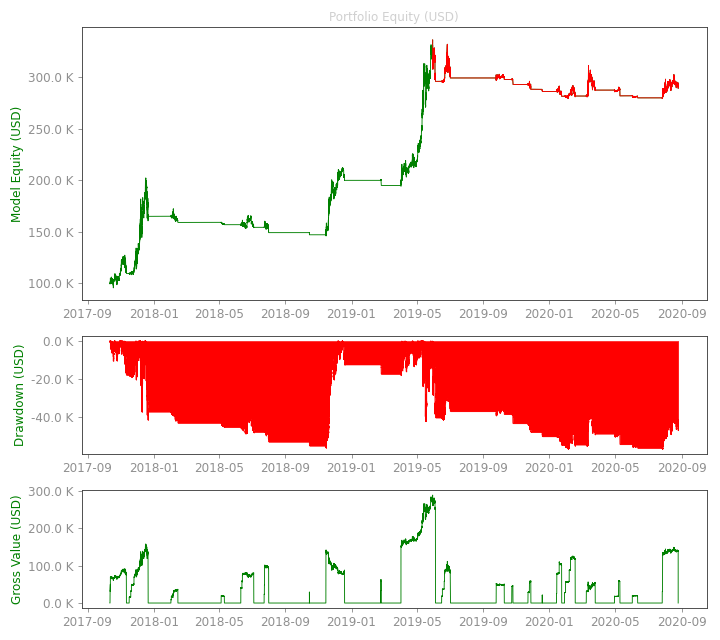

<Figure size 720x640 with 0 Axes>

In [10]:
tearsheet(backtest(instrument, s_classic_2, ohlc5M), 100000)

<hr/>
Backtest results look obvious as it catches significant trends movements but most of times it doesn't generate profit.

Also it has enough big period of drawdown - 60% drops during year
<hr/>

## Using optimal rolling window findings

Now we can try to apply our findings from rolling window research we did earlier.
As we found best parameters from [1. Running HiLo Breakout](./1.%20Running%20HiLo%20Breakout.ipynb) we will use 1H timeframe and 10 bars period for detecting breakouts.

We will use 5 minutes timeframe for trading estimation and trade on close prices.

In [11]:
rhi_enter = RollingHiLo(ohlc1H, 10)
rhi_exit = RollingHiLo(ohlc1H, 10)

### Strategy1: trade after lose only

In [12]:
t_roll_best1 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=5000, dollar_per_point=1, after_lose_only=True, atr_period='1H')
s_roll_best1 = t_roll_best1.get_signals(ohlc5M)

Interesting to see positions sizes during whole period:

<BarContainer object of 2014 artists>

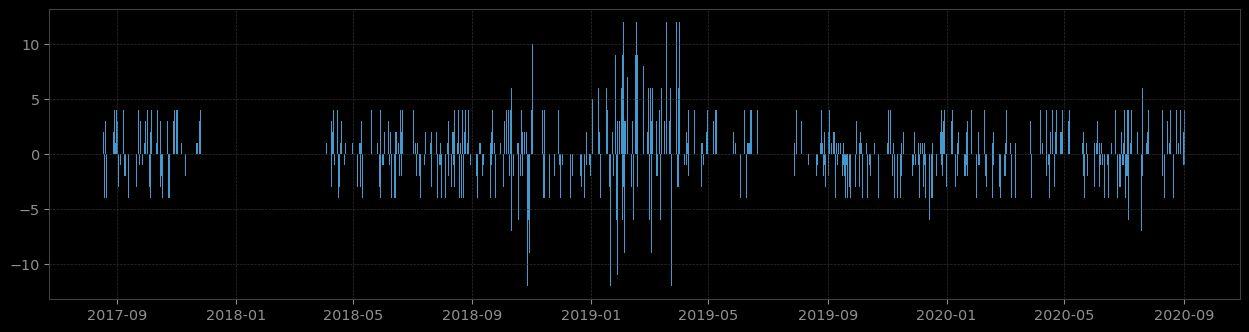

In [13]:
fig(16, 4)
plt.bar(s_roll_best1.index, s_roll_best1[0])

2020-10-27 14:23:10,047 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 10:34:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,48033.71
CAGR (%):,70.786
Sharpe:,1.121
Sortino:,2.783
Calmar:,1.883
MaxDD (%):,47.342
MaxDD On Init BP (%):,162.221
MaxDD (USD):,8111.070
MaxDD days:,351 days
MaxDD start:,2017-11-29

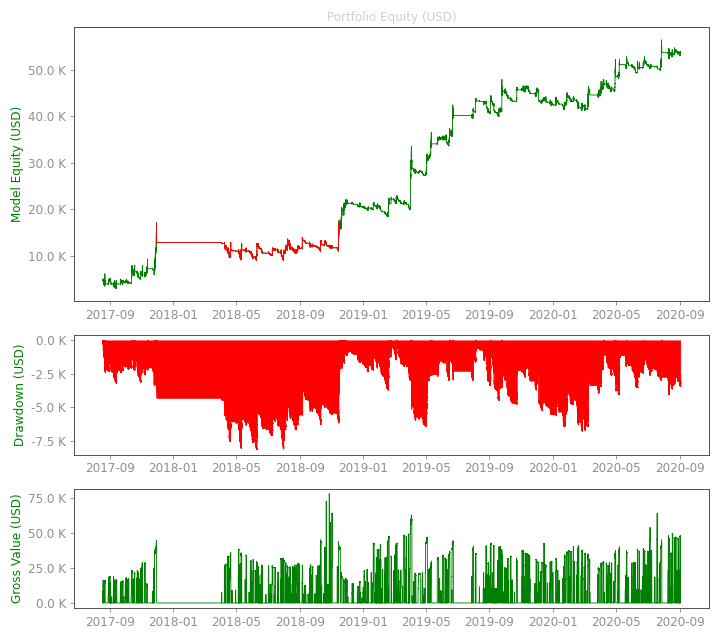

<Figure size 720x640 with 0 Axes>

In [14]:
tearsheet(backtest(instrument, s_roll_best1, ohlc5M), 5000)

<hr/>
Looks not bad but we can see many lose trades, drawdown is also big (64% during year)  
<hr/>

### Strategy2: trade after all the time

In [15]:
t_roll_best2 = TurtlesGenerator(rhi_enter, rhi_exit, account_size=5000, dollar_per_point=1, after_lose_only=False, atr_period='1H')
s_roll_best2 = t_roll_best2.get_signals(ohlc5M)

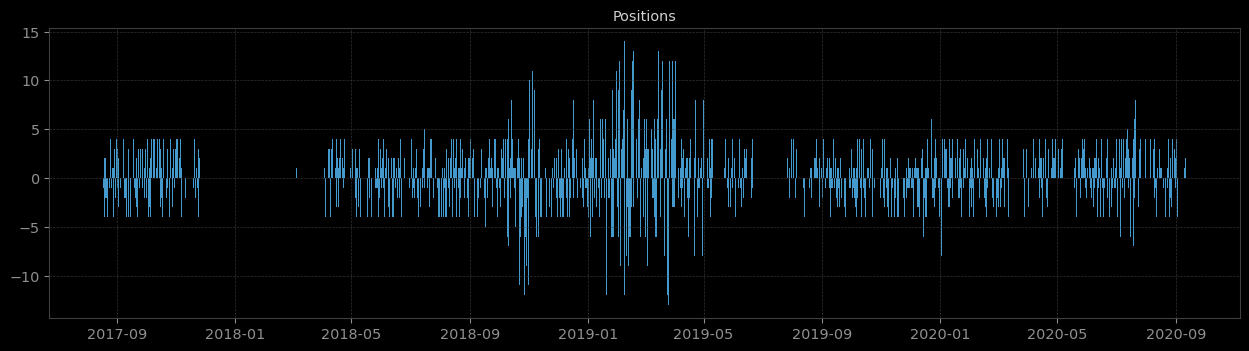

In [16]:
fig(16, 4)
plt.bar(s_roll_best2.index, s_roll_best2[0])
plt.title('Positions');

2020-10-27 14:25:09,731 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 01:24:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,54737.54
CAGR (%):,74.738
Sharpe:,0.997
Sortino:,2.284
Calmar:,1.240
MaxDD (%):,14.743
MaxDD On Init BP (%):,170.663
MaxDD (USD):,8533.130
MaxDD days:,187 days
MaxDD start:,2019-10-26

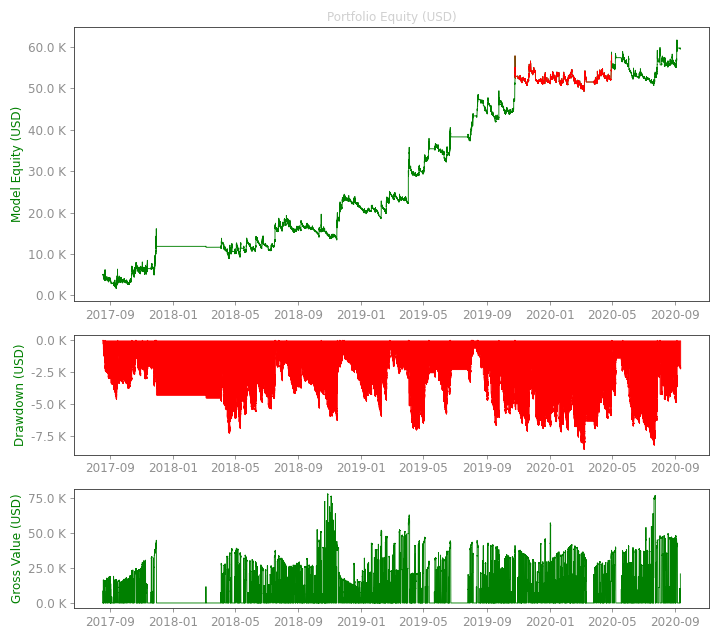

<Figure size 720x640 with 0 Axes>

In [17]:
tearsheet(backtest(instrument, s_roll_best2, ohlc5M), 5000)

<hr/>
Looks much better in sense of drawdown - 24% and only 38 days period. Also it shows highest average daily return compared to other models.
So for rolling Hi/Low breakouts this variation looks best !
<hr/>

# Turtles model on pivot points

Here we will use found parameters for best pivots parameters from this research: [2. Pivot Points Breakout](./2.%20Pivot%20Points%20Breakout.ipynb) 

Weekly pivots based on 'camarilla' calculations method.

Here we need to do bit more job to get entries/exits signals for both directions of tradings

In [34]:
def generate_pivots_sigs(instrument, ohlc, pivots_frame, meth, account_size, after_lose_only, atr_period):

    # long entries: we go long on price breaks up resistance levels
    pb_enters_lo = PivotsBreaks(ohlc,
                      ['R4', 'R3', 'R2', 'R1'],
                      [], 
                      pp_frame=pivots_frame,  method=meth)

    # and exits on price breaks down central P or supports levels
    pb_exits_lo = PivotsBreaks(ohlc,
                      [],
                      ['P', 'S1', 'S2', 'S3', 'S4'],
                      pp_frame=pivots_frame,  method=meth)

    # short entries: we go short on price breaks down support levels
    pb_enters_sh = PivotsBreaks(ohlc,
                      [], 
                      ['S1', 'S2', 'S3', 'S4'], 
                      pp_frame=pivots_frame,  method=meth)

    # and exits on price breaks up central P or resistance levels
    pb_exits_sh = PivotsBreaks(ohlc,
                      ['R4', 'R3', 'R2', 'R1', 'P'],
                      [],
                      pp_frame=pivots_frame,  method=meth)
    
    t_pvt1_lo = TurtlesGenerator(pb_enters_lo, pb_exits_lo, account_size=account_size, dollar_per_point=1, after_lose_only=after_lose_only, atr_period=atr_period)
    s_pvt1_lo = t_pvt1_lo.get_signals(ohlc)

    t_pvt1_sh = TurtlesGenerator(pb_enters_sh, pb_exits_sh, account_size=account_size, dollar_per_point=1, after_lose_only=after_lose_only, atr_period=atr_period)
    s_pvt1_sh = t_pvt1_sh.get_signals(ohlc)

    return scols(s_pvt1_lo, s_pvt1_sh).fillna(0).sum(axis=1).rename(instrument)

<hr/>
Strategy 1: open after lose only 
<hr/>

2020-10-27 14:26:26,376 - ira.simulator.SignalTester - WARNING - Positions at [2017-09-12 08:59:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,88764.60
CAGR (%):,97.181
Sharpe:,1.396
Sortino:,2.975
Calmar:,1.987
MaxDD (%):,51.356
MaxDD On Init BP (%):,549.785
MaxDD (USD):,27489.260
MaxDD days:,510 days
MaxDD start:,2017-12-17

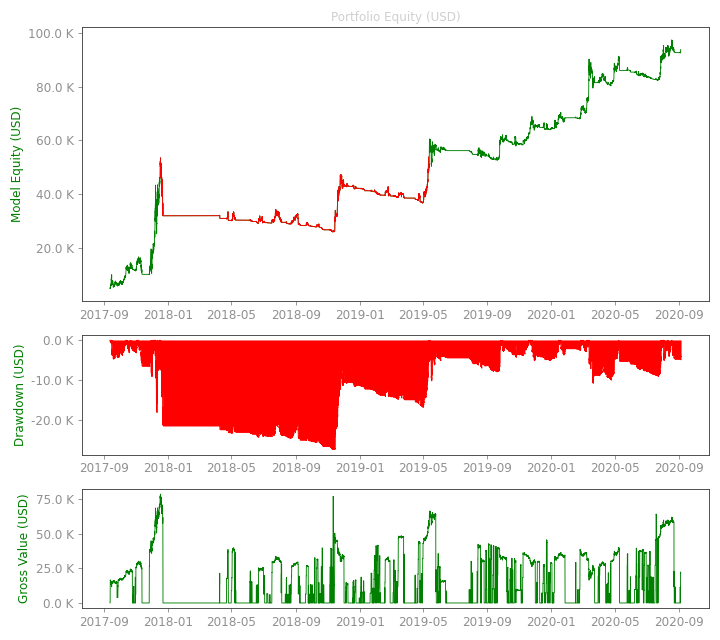

<Figure size 720x640 with 0 Axes>

In [19]:
s_pvt1 = generate_pivots_sigs(instrument, ohlc1H, 'W', 'camarilla', 5000, True, '1H')
tearsheet(backtest(instrument, s_pvt1, ohlc1H), 5000)

<hr/>
Strategy 2: open on any signal
<hr/>

<font size=2 color='green'>Weekly/Camarilla</font>

2020-10-27 14:27:13,972 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-28 07:59:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,102554.03
CAGR (%):,101.590
Sharpe:,1.293
Sortino:,2.557
Calmar:,1.946
MaxDD (%):,47.170
MaxDD On Init BP (%):,485.960
MaxDD (USD):,24297.990
MaxDD days:,471 days
MaxDD start:,2017-12-17

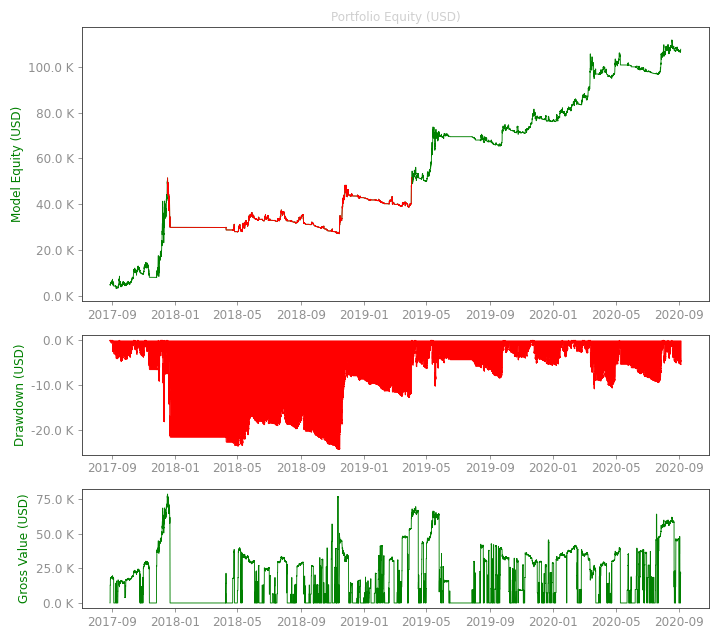

<Figure size 720x640 with 0 Axes>

In [20]:
s_pvt2 = generate_pivots_sigs(instrument, ohlc1H, 'W', 'camarilla', 5000, False, '1H')
tearsheet(backtest(instrument, s_pvt2, ohlc1H), 5000)

<font size=2 color='green'>Daily/Camarilla</font>
<hr/>

2020-10-27 14:27:51,899 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 01:59:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,71604.05
CAGR (%):,84.794
Sharpe:,0.922
Sortino:,2.778
Calmar:,1.227
MaxDD (%):,8.951
MaxDD On Init BP (%):,103.654
MaxDD (USD):,5182.690
MaxDD days:,63 days
MaxDD start:,2019-11-25

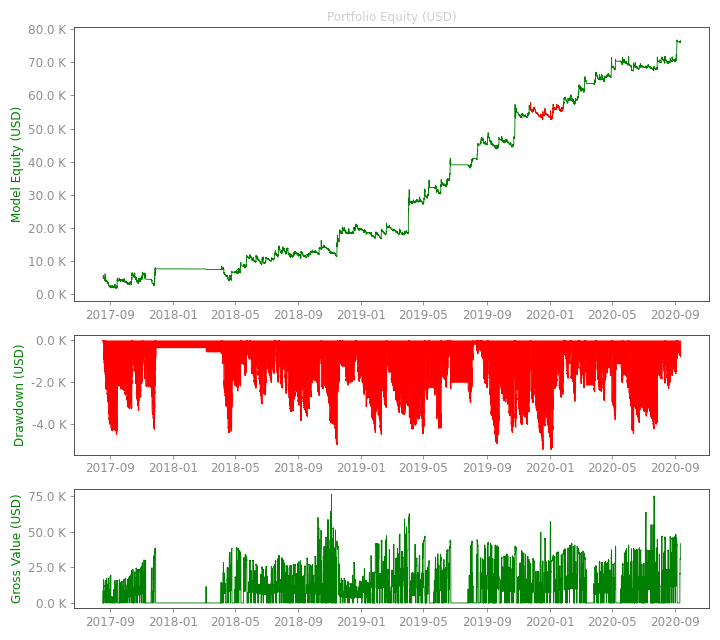

<Figure size 720x640 with 0 Axes>

In [21]:
s_pvt3 = generate_pivots_sigs(instrument, ohlc1H, 'D', 'camarilla', 5000, False, '1H')
tearsheet(backtest(instrument, s_pvt3, ohlc1H), 5000)

<font size=2 color='green'>Daily/Classic</font>
<hr/>

2020-10-27 14:28:30,242 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 18:59:59] will be skipped: no prices found
/usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/analysis/portfolio.py:306: RuntimeWarning:

invalid value encountered in log1p



Statistic,Model
Gain (USD):,59732.88
CAGR (%):,77.924
Sharpe:,-0.383
Sortino:,-0.385
Calmar:,0.772
MaxDD (%):,85.770
MaxDD On Init BP (%):,202.181
MaxDD (USD):,10109.050
MaxDD days:,236 days
MaxDD start:,2017-11-29

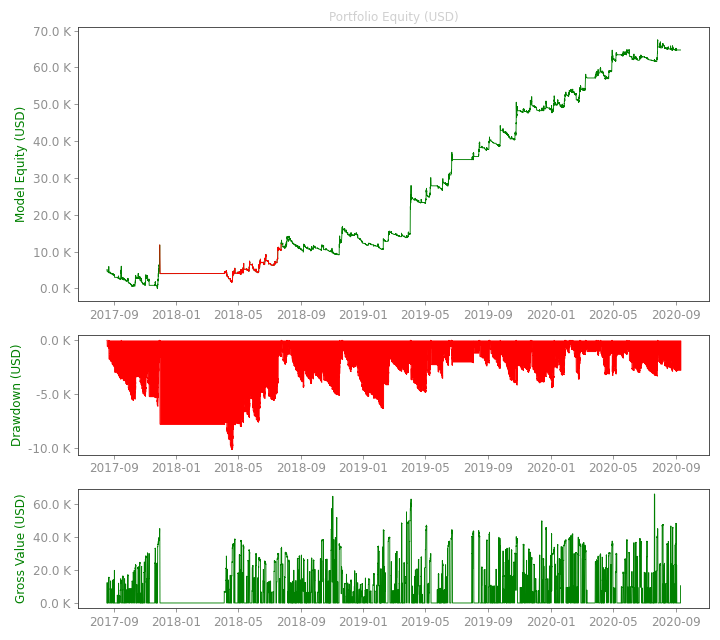

<Figure size 720x640 with 0 Axes>

In [22]:
s_pvt4 = generate_pivots_sigs(instrument, ohlc1H, 'D', 'classic', 5000, False, '1H')
tearsheet(backtest(instrument, s_pvt4, ohlc1H), 5000)

# Conclusions
<hr/>

It seems both models (classical rolling hi/low and pivot points) may be used for trading on crypto market using modified Turtles strategy with comparable small drawdown (21% - 24%).

There is another question about transaction costs - but it can be decreased if trade on futures/swaps assets.

# Backtest results

In [21]:
sim_pfl = split_cumulative_pnl(z_load('Turtles1@TurtlesStrategy', dbname='IRA_simulations_portfolio_logs')['data'])

Statistic,Model
Gain (USD):,1309.25
CAGR (%):,36.055
Sharpe:,0.884
Sortino:,3.897
Calmar:,2.089
MaxDD (%):,33.535
MaxDD On Init BP (%):,78.146
MaxDD (USD):,781.461
MaxDD days:,205 days
MaxDD start:,2019-04-03

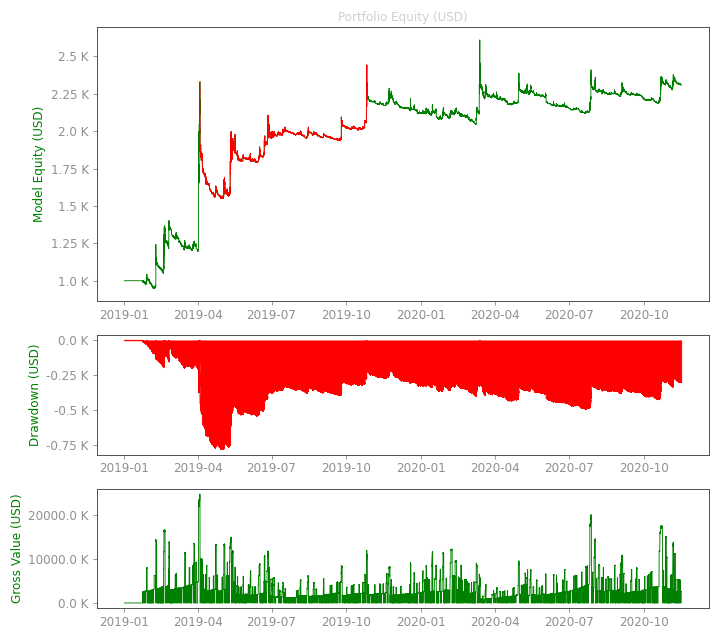

<Figure size 720x640 with 0 Axes>

In [23]:
tearsheet(sim_pfl, 1000, commissions='bitmex')

# ETH tests

In [13]:
eth = prepare_data('ETHUSDT')

2020-11-16 15:22:40,722 - ira.simulator.SignalTester - WARNING - Positions at [2019-01-02 07:14:59] will be skipped: no prices found


Statistic,Model
Gain (USD):,49274.16
CAGR (%):,164.419
Sharpe:,1.405
Sortino:,3.160
Calmar:,3.154
MaxDD (%):,42.205
MaxDD On Init BP (%):,199.773
MaxDD (USD):,9988.650
MaxDD days:,73 days
MaxDD start:,2019-11-25

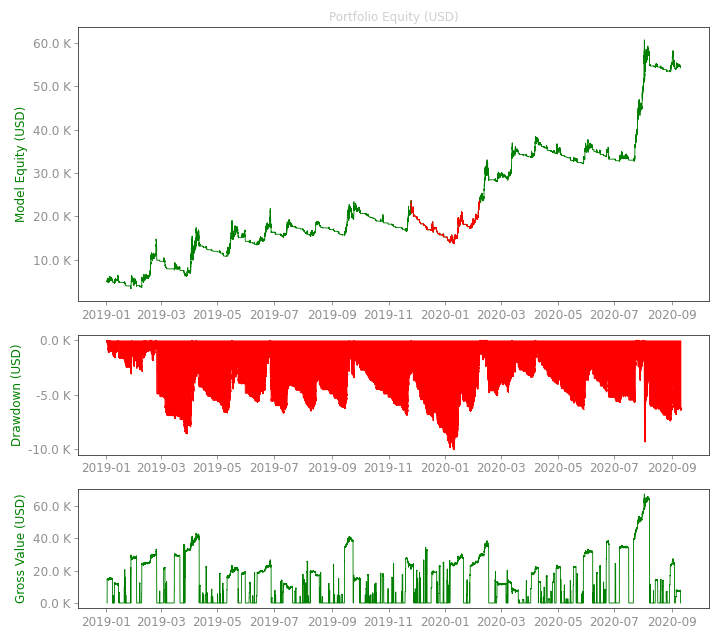

<Figure size 720x640 with 0 Axes>

In [32]:
te = RollingHiLo(eth.D1, 3)
tx = RollingHiLo(eth.D1, 3)
s_roll1 = TurtlesGenerator(te, tx, account_size=5000, dollar_per_point=1, after_lose_only=False, atr_period='1H').get_signals(eth.M5)

tearsheet(backtest(eth.instrument, s_roll1['2019':], eth.M5), 5000)

2020-11-16 16:54:27,561 - ira.simulator.SignalTester - WARNING - Positions at [2017-08-18 10:49:59] will be skipped: no prices found
/usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/analysis/portfolio.py:306: RuntimeWarning:

invalid value encountered in log1p



Statistic,Model
Gain (USD):,15646.45
CAGR (%):,37.585
Sharpe:,-0.398
Sortino:,-0.457
Calmar:,0.336
MaxDD (%):,48.551
MaxDD On Init BP (%):,235.219
MaxDD (USD):,11760.930
MaxDD days:,642 days
MaxDD start:,2018-12-07

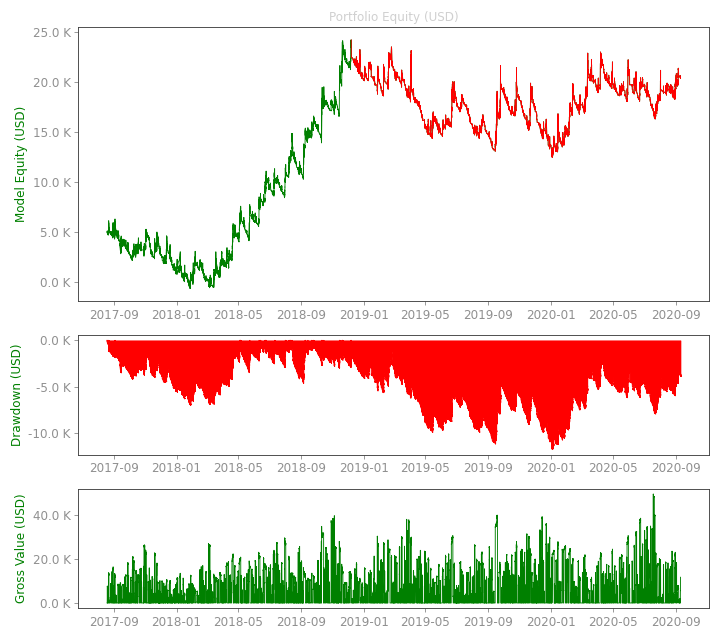

<Figure size 720x640 with 0 Axes>

In [38]:
s_pvt1 = generate_pivots_sigs(eth.instrument, eth.M5, 'D', 'classic', 5000, False, '1H')
tearsheet(backtest(eth.instrument, s_pvt1, eth.M5), 5000)

Statistic,Model
Gain (USD):,91103.12
CAGR (%):,196.202
Sharpe:,1.605
Sortino:,3.916
Calmar:,4.441
MaxDD (%):,37.665
MaxDD On Init BP (%):,434.162
MaxDD (USD):,21708.078
MaxDD days:,246 days
MaxDD start:,2019-05-16

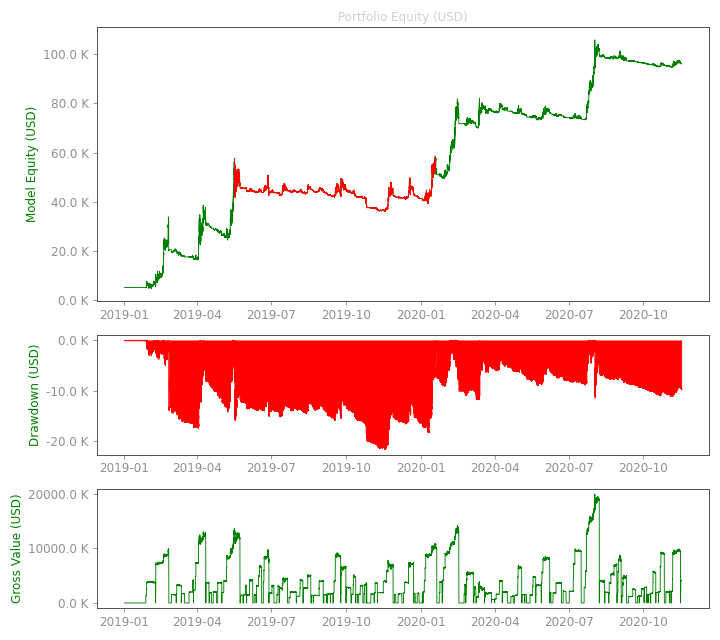

<Figure size 720x640 with 0 Axes>

In [40]:
eth_pfl = split_cumulative_pnl(z_load('Turtles2@TurtlesStrategy', dbname='IRA_simulations_portfolio_logs')['data'])
tearsheet(eth_pfl, 5000, commissions='bitmex')